# TASK-1: Movie Audience Segmentation (Clustering) - Synthetic Data

**Goal:** Group movies into meaningful audience segments based on engagement and popularity using the synthetic dataset (1200 movies).

**Dataset:** synthetic_movies.csv (1200 movies)

---

## Understand & Audit the Data

With a larger synthetic dataset, we can perform more robust clustering and validation.

In [26]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Load Synthetic Dataset
df = pd.read_csv("../Dataset/synthetic/synthetic_movies.csv")
print("Dataset Shape:", df.shape)
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Data Info ---")
print(df.info())
print("\n--- Statistical Summary ---")
print(df.describe())

Dataset Shape: (1200, 6)

--- First 5 Rows ---
   movie_id  avg_watch_time  completion_rate  ratings_count  avg_rating  hit
0         1              82             0.67           6176         3.7    1
1         2              94             0.98           7178         4.2    1
2         3              49             0.63           2095         3.4    0
3         4              84             0.81           3398         4.4    0
4         5              60             0.57           1076         3.6    0

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         1200 non-null   int64  
 1   avg_watch_time   1200 non-null   int64  
 2   completion_rate  1200 non-null   float64
 3   ratings_count    1200 non-null   int64  
 4   avg_rating       1200 non-null   float64
 5   hit              1200 non-null   int64 

In [28]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n--- Target Distribution (hit) ---")
print(df['hit'].value_counts())
print(f"\nHit Rate: {df['hit'].mean()*100:.2f}%")

Missing Values:
movie_id           0
avg_watch_time     0
completion_rate    0
ratings_count      0
avg_rating         0
hit                0
dtype: int64

--- Target Distribution (hit) ---
hit
1    600
0    600
Name: count, dtype: int64

Hit Rate: 50.00%


## Exploratory Data Analysis (EDA)

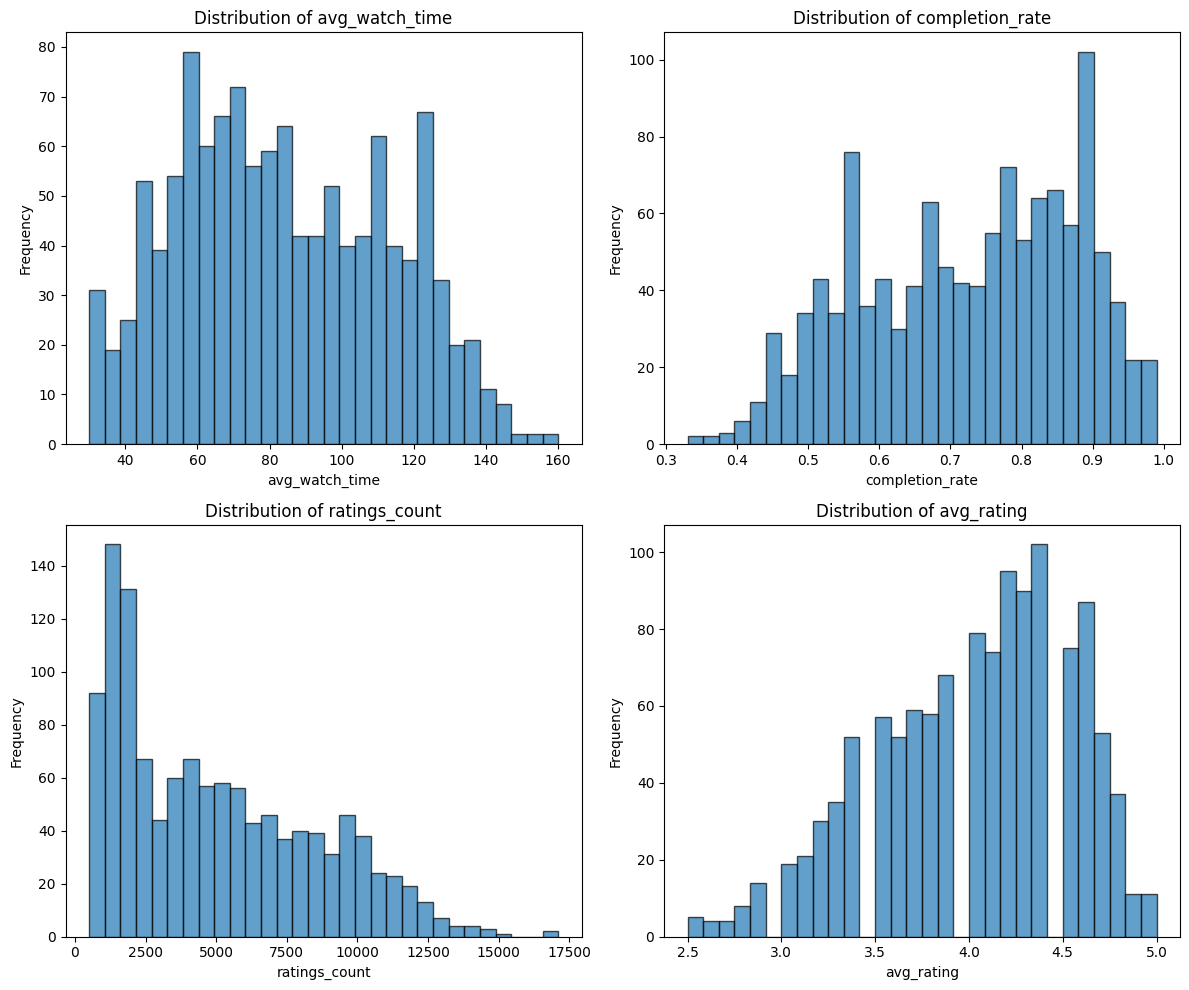

In [29]:
# Distribution of features
features = ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, feature in enumerate(features):
    ax = axes[idx//2, idx%2]
    ax.hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

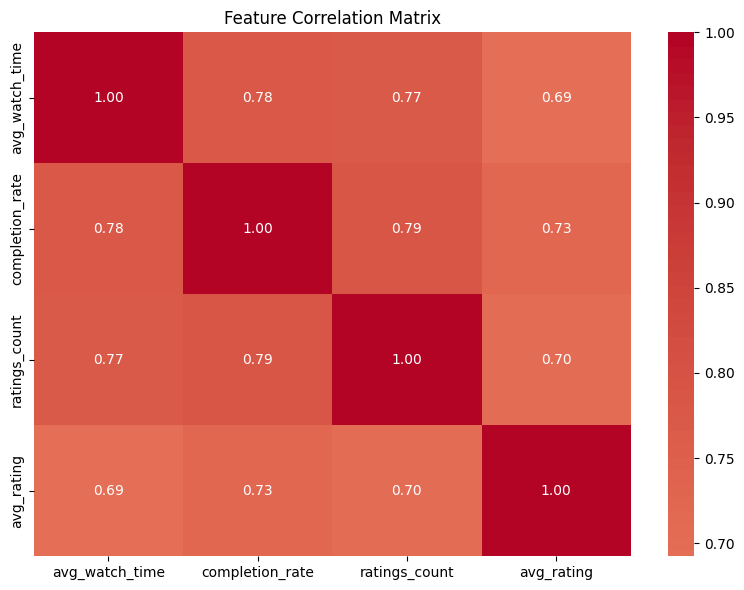

In [30]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Create Engagement & Popularity Features

**Objective:** Group movies based on two key factors:
- **Engagement:** How much viewers watch (avg_watch_time, completion_rate)
- **Popularity:** How many people rated and how well (ratings_count, avg_rating)

In [32]:
# Create composite features for Engagement and Popularity
# Normalize each feature to 0-1 scale before combining
from sklearn.preprocessing import MinMaxScaler

scaler_norm = MinMaxScaler()
df_norm = pd.DataFrame(scaler_norm.fit_transform(df[features]), columns=features)

# Engagement = avg of normalized watch_time and completion_rate
df['engagement'] = (df_norm['avg_watch_time'] + df_norm['completion_rate']) / 2

# Popularity = avg of normalized ratings_count and avg_rating
df['popularity'] = (df_norm['ratings_count'] + df_norm['avg_rating']) / 2

print("Created Engagement & Popularity features:")
print(df[['movie_id', 'engagement', 'popularity', 'hit']].head(10))
print("\nFeature Statistics:")
print(df[['engagement', 'popularity']].describe())

Created Engagement & Popularity features:
   movie_id  engagement  popularity  hit
0         1    0.457576    0.410892    1
1         2    0.738578    0.541060    1
2         3    0.300350    0.228022    0
3         4    0.571329    0.467252    0
4         5    0.297203    0.237342    0
5         6    0.456643    0.443399    1
6         7    0.336597    0.192766    0
7         8    0.656061    0.642682    1
8         9    0.212587    0.241867    0
9        10    0.801166    0.664505    1

Feature Statistics:
        engagement   popularity
count  1200.000000  1200.000000
mean      0.505723     0.439908
std       0.212344     0.193095
min       0.069231     0.011230
25%       0.314977     0.273195
50%       0.499359     0.445448
75%       0.712617     0.599088
max       0.946387     0.893166


In [33]:
# Use Engagement and Popularity for clustering
cluster_features = ['engagement', 'popularity']
X = df[cluster_features]

# Scale for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Clustering Features:")
print(X.head())

Clustering Features:
   engagement  popularity
0    0.457576    0.410892
1    0.738578    0.541060
2    0.300350    0.228022
3    0.571329    0.467252
4    0.297203    0.237342


## Determine Optimal Number of Clusters

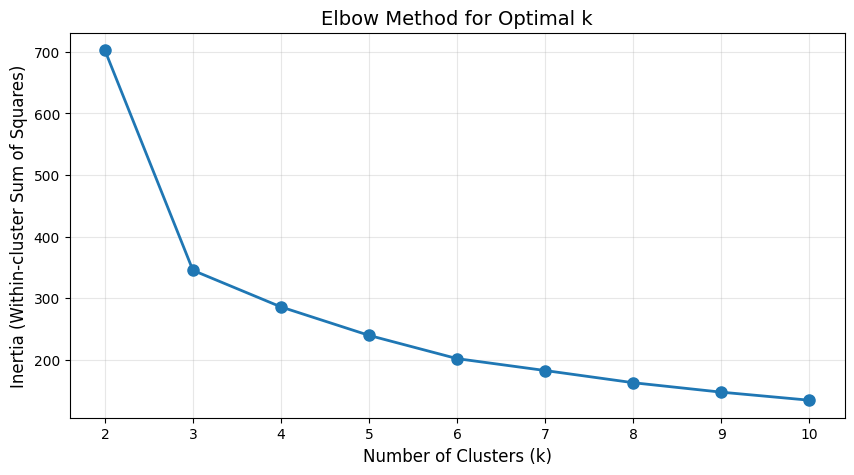

In [34]:
# Elbow Method
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linewidth=2, markersize=8)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Inertia (Within-cluster Sum of Squares)", fontsize=12)
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.show()

k=2: Silhouette Score = 0.5670
k=3: Silhouette Score = 0.5463
k=4: Silhouette Score = 0.4584
k=5: Silhouette Score = 0.3847
k=6: Silhouette Score = 0.3511
k=7: Silhouette Score = 0.3355
k=8: Silhouette Score = 0.3362
k=9: Silhouette Score = 0.3325
k=10: Silhouette Score = 0.3305


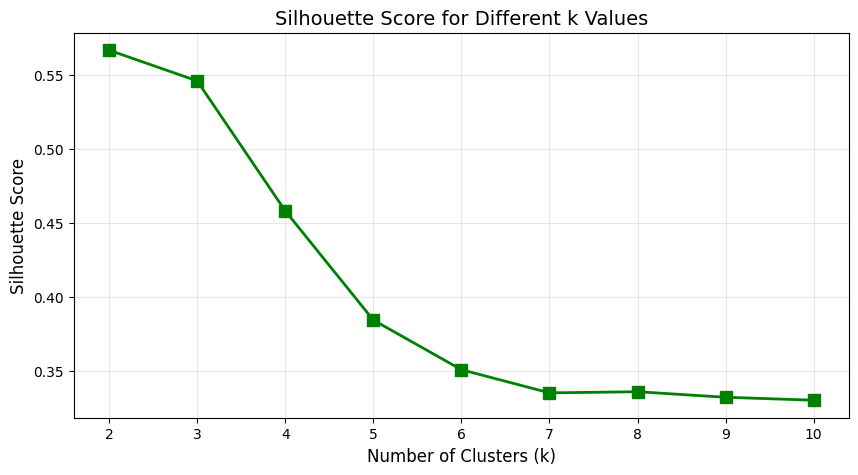


✅ Optimal number of clusters based on Silhouette Score: k=2


In [35]:
# Silhouette Score Analysis
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Score for Different k Values", fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal number of clusters based on Silhouette Score: k={optimal_k}")

## Cluster Interpretation

In [37]:
# Cluster Summary - Focus on Engagement & Popularity
print("=== Cluster Summary (Engagement & Popularity) ===\n")
cluster_summary = df.groupby('cluster')[['engagement', 'popularity']].mean()
print(cluster_summary)

print("\n=== Original Feature Means by Cluster ===\n")
print(df.groupby('cluster')[features].mean())

=== Cluster Summary (Engagement & Popularity) ===

         engagement  popularity
cluster                        
0          0.331082    0.283694
1          0.691167    0.605784

=== Original Feature Means by Cluster ===

         avg_watch_time  completion_rate  ratings_count  avg_rating
cluster                                                            
0             61.522654         0.606990    2322.079288    3.644175
1            107.451890         0.849124    7858.805842    4.421134


In [38]:
# Hit Rate by Cluster
print("=== Hit Rate by Cluster ===\n")
hit_by_cluster = df.groupby('cluster')['hit'].agg(['sum', 'count', 'mean'])
hit_by_cluster.columns = ['Total Hits', 'Total Movies', 'Hit Rate']
hit_by_cluster['Hit Rate'] = hit_by_cluster['Hit Rate'] * 100
print(hit_by_cluster)

=== Hit Rate by Cluster ===

         Total Hits  Total Movies   Hit Rate
cluster                                     
0               143           618  23.139159
1               457           582  78.522337


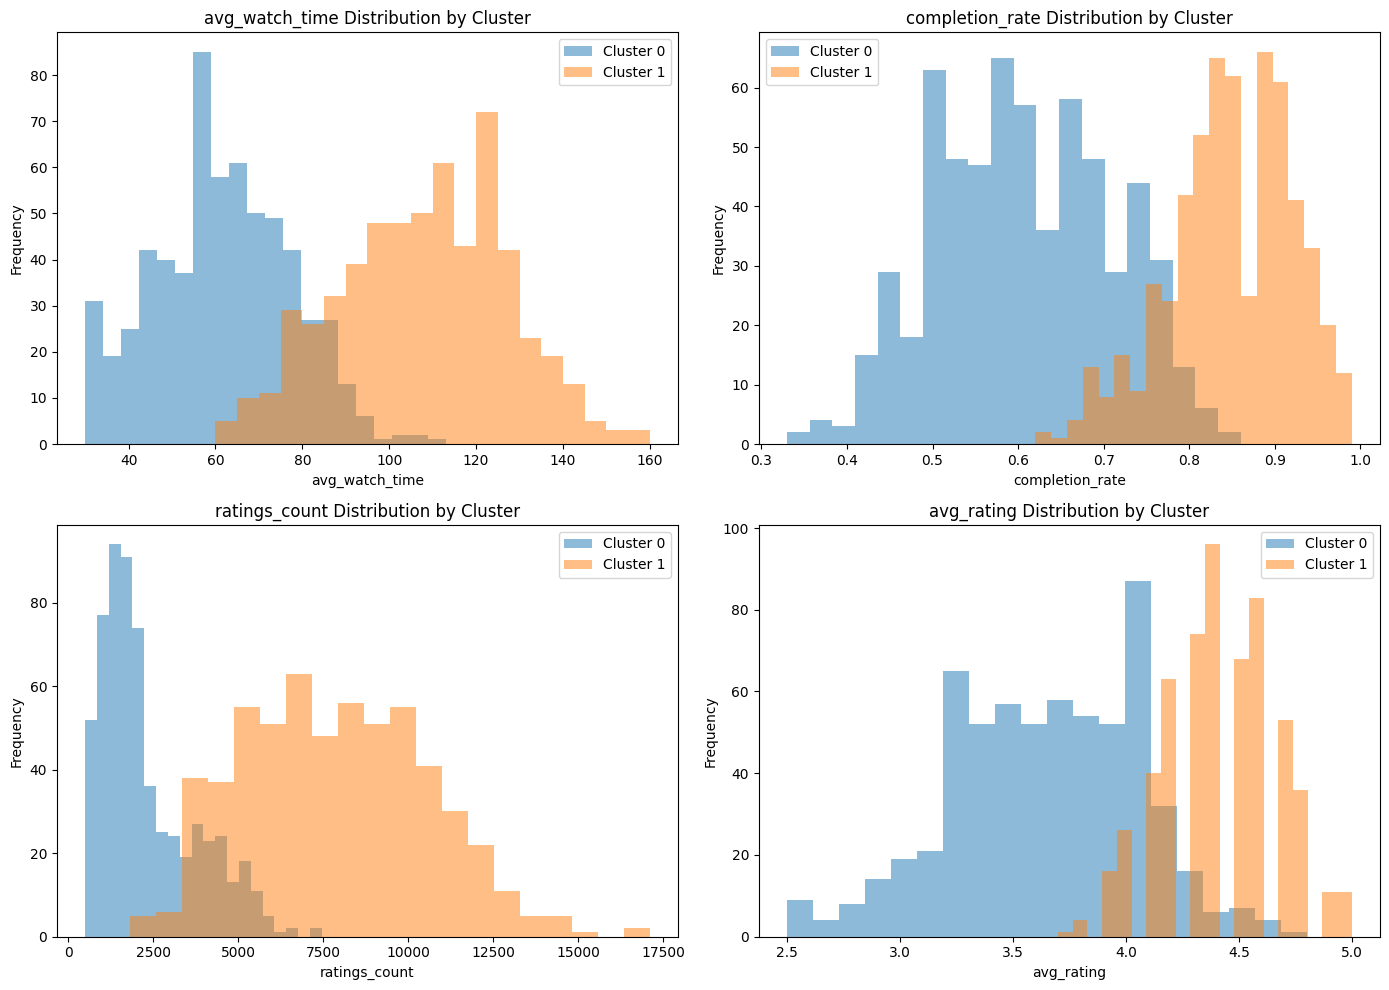

In [39]:
# Visualize cluster profiles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feature in enumerate(features):
    ax = axes[idx//2, idx%2]
    for cluster in range(n_clusters):
        cluster_data = df[df['cluster'] == cluster][feature]
        ax.hist(cluster_data, bins=20, alpha=0.5, label=f'Cluster {cluster}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature} Distribution by Cluster')
    ax.legend()

plt.tight_layout()
plt.show()

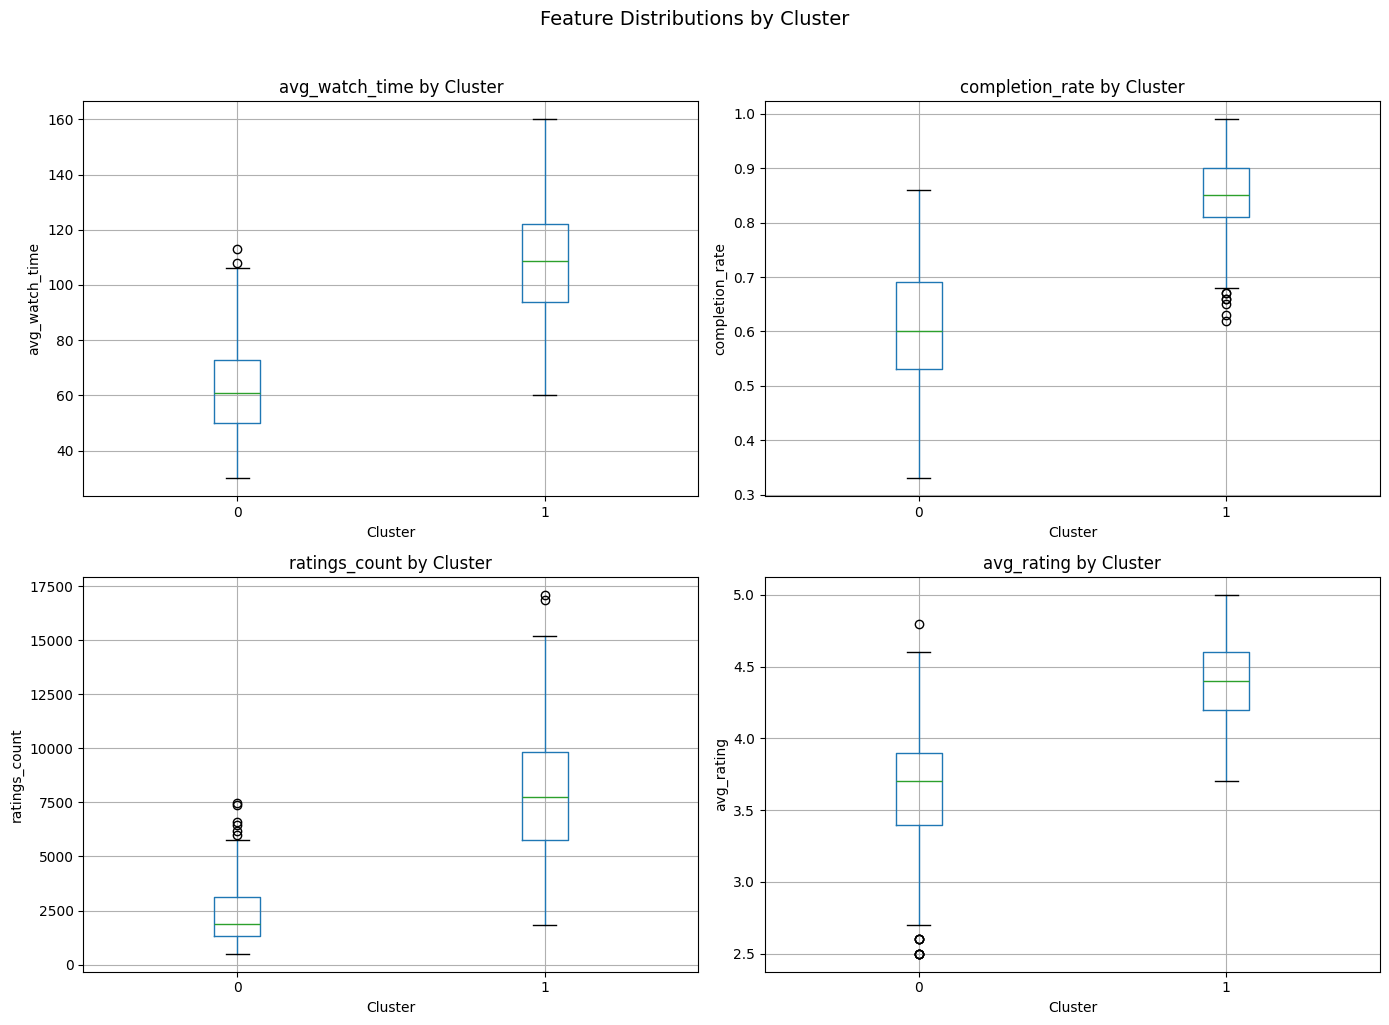

In [40]:
# Box plots for cluster comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feature in enumerate(features):
    ax = axes[idx//2, idx%2]
    df.boxplot(column=feature, by='cluster', ax=ax)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} by Cluster')

plt.suptitle('Feature Distributions by Cluster', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Visualize Clusters using PCA

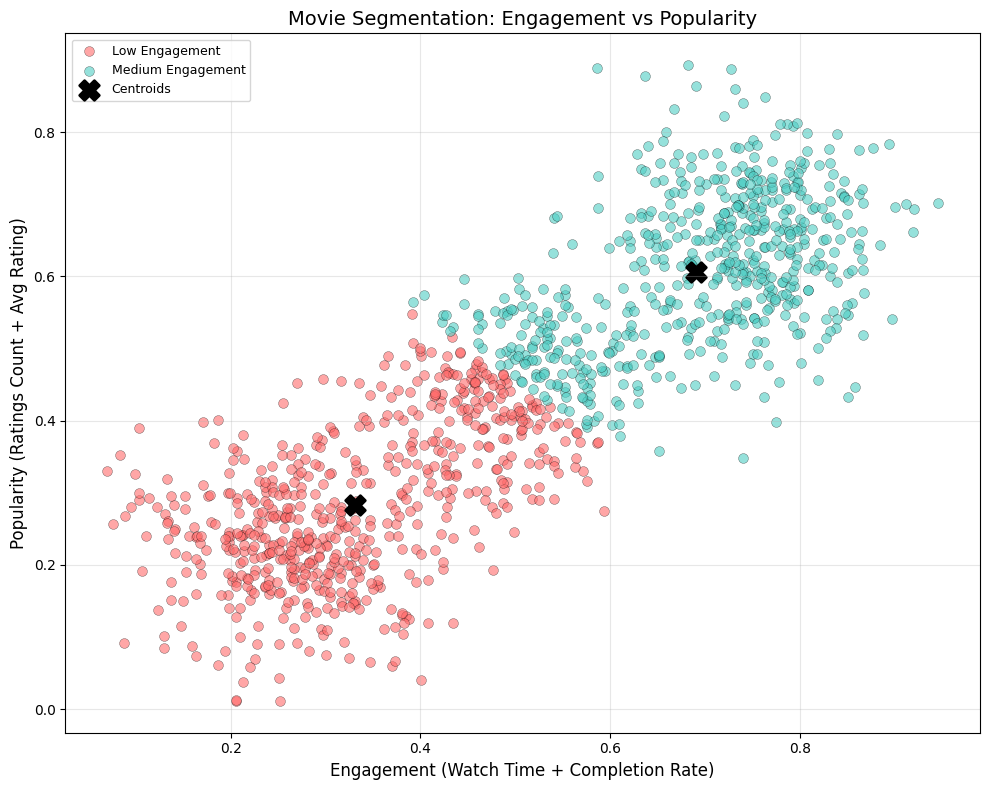

In [41]:
# Direct visualization - Engagement vs Popularity (no PCA needed for 2 features)
plt.figure(figsize=(10, 8))

# Plot each cluster
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for cluster_id in sorted(df['cluster'].unique()):
    mask = df['cluster'] == cluster_id
    plt.scatter(df.loc[mask, 'engagement'], df.loc[mask, 'popularity'], 
                c=colors[cluster_id], s=50, alpha=0.6, 
                label=cluster_labels[cluster_id], edgecolors='black', linewidth=0.3)

# Plot centroids
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', 
            s=200, linewidth=2, label='Centroids')

plt.xlabel('Engagement (Watch Time + Completion Rate)', fontsize=12)
plt.ylabel('Popularity (Ratings Count + Avg Rating)', fontsize=12)
plt.title('Movie Segmentation: Engagement vs Popularity', fontsize=14)
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

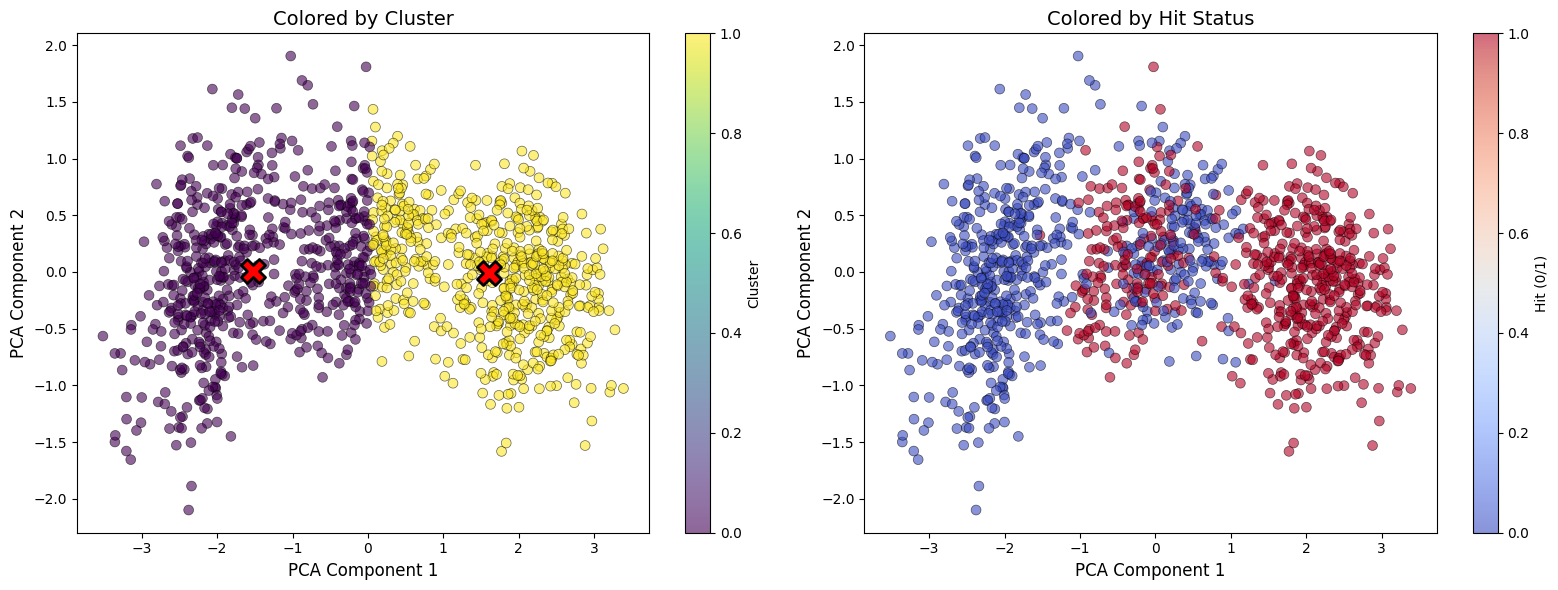

In [42]:
# PCA visualization with hit status overlay
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By Cluster
ax1 = axes[0]
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', 
                       s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
            s=300, edgecolors='black', linewidth=2)
ax1.set_xlabel(f"PCA Component 1", fontsize=12)
ax1.set_ylabel(f"PCA Component 2", fontsize=12)
ax1.set_title("Colored by Cluster", fontsize=14)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# By Hit Status
ax2 = axes[1]
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=df['hit'], cmap='coolwarm', 
                       s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f"PCA Component 1", fontsize=12)
ax2.set_ylabel(f"PCA Component 2", fontsize=12)
ax2.set_title("Colored by Hit Status", fontsize=14)
plt.colorbar(scatter2, ax=ax2, label='Hit (0/1)')

plt.tight_layout()
plt.show()

## Cluster Naming and Interpretation

In [43]:
# Generate cluster interpretations based on statistics
print("=== CLUSTER INTERPRETATIONS ===\n")

for cluster_id in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"--- Cluster {cluster_id} ({len(cluster_data)} movies) ---")
    print(f"  Avg Watch Time: {cluster_data['avg_watch_time'].mean():.1f} min")
    print(f"  Avg Completion Rate: {cluster_data['completion_rate'].mean():.2f}")
    print(f"  Avg Ratings Count: {cluster_data['ratings_count'].mean():.0f}")
    print(f"  Avg Rating: {cluster_data['avg_rating'].mean():.2f}")
    print(f"  Hit Rate: {cluster_data['hit'].mean()*100:.1f}%")
    print()

=== CLUSTER INTERPRETATIONS ===

--- Cluster 0 (618 movies) ---
  Avg Watch Time: 61.5 min
  Avg Completion Rate: 0.61
  Avg Ratings Count: 2322
  Avg Rating: 3.64
  Hit Rate: 23.1%

--- Cluster 1 (582 movies) ---
  Avg Watch Time: 107.5 min
  Avg Completion Rate: 0.85
  Avg Ratings Count: 7859
  Avg Rating: 4.42
  Hit Rate: 78.5%



In [44]:
# Create cluster labels based on Engagement & Popularity
cluster_labels = {}
cluster_means = df.groupby('cluster')[['engagement', 'popularity']].mean()

# Label based on engagement and popularity levels
for cluster_id in cluster_means.index:
    eng = cluster_means.loc[cluster_id, 'engagement']
    pop = cluster_means.loc[cluster_id, 'popularity']
    
    if eng > 0.5 and pop > 0.5:
        cluster_labels[cluster_id] = 'Blockbusters (High Engagement & Popularity)'
    elif eng > 0.5 and pop <= 0.5:
        cluster_labels[cluster_id] = 'Cult Classics (High Engagement, Low Popularity)'
    elif eng <= 0.5 and pop > 0.5:
        cluster_labels[cluster_id] = 'Trending (Low Engagement, High Popularity)'
    else:
        cluster_labels[cluster_id] = 'Low Performers (Low Engagement & Popularity)'

df['cluster_name'] = df['cluster'].map(cluster_labels)

print("=== Cluster Interpretation ===")
for cluster_id, name in cluster_labels.items():
    count = len(df[df['cluster'] == cluster_id])
    eng = cluster_means.loc[cluster_id, 'engagement']
    pop = cluster_means.loc[cluster_id, 'popularity']
    print(f"\nCluster {cluster_id}: {name}")
    print(f"  Movies: {count}")
    print(f"  Avg Engagement: {eng:.3f}")
    print(f"  Avg Popularity: {pop:.3f}")

=== Cluster Interpretation ===

Cluster 0: Low Performers (Low Engagement & Popularity)
  Movies: 618
  Avg Engagement: 0.331
  Avg Popularity: 0.284

Cluster 1: Blockbusters (High Engagement & Popularity)
  Movies: 582
  Avg Engagement: 0.691
  Avg Popularity: 0.606


## Final Summary

In [45]:
# Final Summary
print("=" * 60)
print("MOVIE AUDIENCE SEGMENTATION - FINAL SUMMARY")
print("=" * 60)
print(f"\nDataset: Synthetic Movies (n={len(df)})")
print(f"Number of Clusters: {n_clusters}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df['cluster']):.4f}")
print("\n--- Cluster Summary (Engagement & Popularity) ---")
summary = df.groupby(['cluster', 'cluster_name']).agg({
    'movie_id': 'count',
    'engagement': 'mean',
    'popularity': 'mean',
    'hit': 'mean'
}).round(3)
summary.columns = ['Count', 'Engagement', 'Popularity', 'Hit Rate']
summary['Hit Rate'] = (summary['Hit Rate'] * 100).round(1).astype(str) + '%'
print(summary)

MOVIE AUDIENCE SEGMENTATION - FINAL SUMMARY

Dataset: Synthetic Movies (n=1200)
Number of Clusters: 2
Silhouette Score: 0.5670

--- Cluster Summary (Engagement & Popularity) ---
                                                      Count  Engagement  \
cluster cluster_name                                                      
0       Low Performers (Low Engagement & Popularity)    618       0.331   
1       Blockbusters (High Engagement & Popularity)     582       0.691   

                                                      Popularity Hit Rate  
cluster cluster_name                                                       
0       Low Performers (Low Engagement & Popularity)       0.284    23.1%  
1       Blockbusters (High Engagement & Popularity)        0.606    78.5%  


In [46]:
# Sample movies from each cluster
print("\n=== Sample Movies from Each Cluster ===\n")
for cluster_id in range(n_clusters):
    print(f"--- {cluster_labels[cluster_id]} (Cluster {cluster_id}) ---")
    sample = df[df['cluster'] == cluster_id][['movie_id', 'engagement', 'popularity', 'hit']].head(5)
    print(sample.round(3).to_string(index=False))
    print()


=== Sample Movies from Each Cluster ===

--- Low Performers (Low Engagement & Popularity) (Cluster 0) ---
 movie_id  engagement  popularity  hit
        1       0.458       0.411    1
        3       0.300       0.228    0
        5       0.297       0.237    0
        6       0.457       0.443    1
        7       0.337       0.193    0

--- Blockbusters (High Engagement & Popularity) (Cluster 1) ---
 movie_id  engagement  popularity  hit
        2       0.739       0.541    1
        4       0.571       0.467    0
        8       0.656       0.643    1
       10       0.801       0.665    1
       11       0.748       0.686    1



In [25]:
# Save clustered data
df.to_csv("../Dataset/synthetic/synthetic_movies_clustered.csv", index=False)
print("✅ Clustered data saved to: ../Dataset/synthetic/synthetic_movies_clustered.csv")

✅ Clustered data saved to: ../Dataset/synthetic/synthetic_movies_clustered.csv
